In [32]:
import torch
import numpy as np
from torchvision import datasets, transforms
import torchvision

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import OrderedDict
from collections import namedtuple
from itertools import product

from torch.utils.tensorboard import SummaryWriter

import pandas as pd
import json
from IPython.display import display, clear_output
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
transform = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,),)])

train_set = datasets.FashionMNIST('./fashion_mnist_data', download=True, train=True, transform=transform)
test_set = datasets.FashionMNIST('./fashion_mnist_data', download=True, train=False, transform=transform)

In [20]:
print('How many images are in traning set?', len(train_set))
print('Labels: ', train_set.targets)
print('Class balance: ', train_set.targets.bincount())

How many images are in traning set? 60000
Labels:  tensor([9, 0, 0,  ..., 3, 0, 5])
Class balance:  tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])


## Plot images by using Pytorch Dataloader

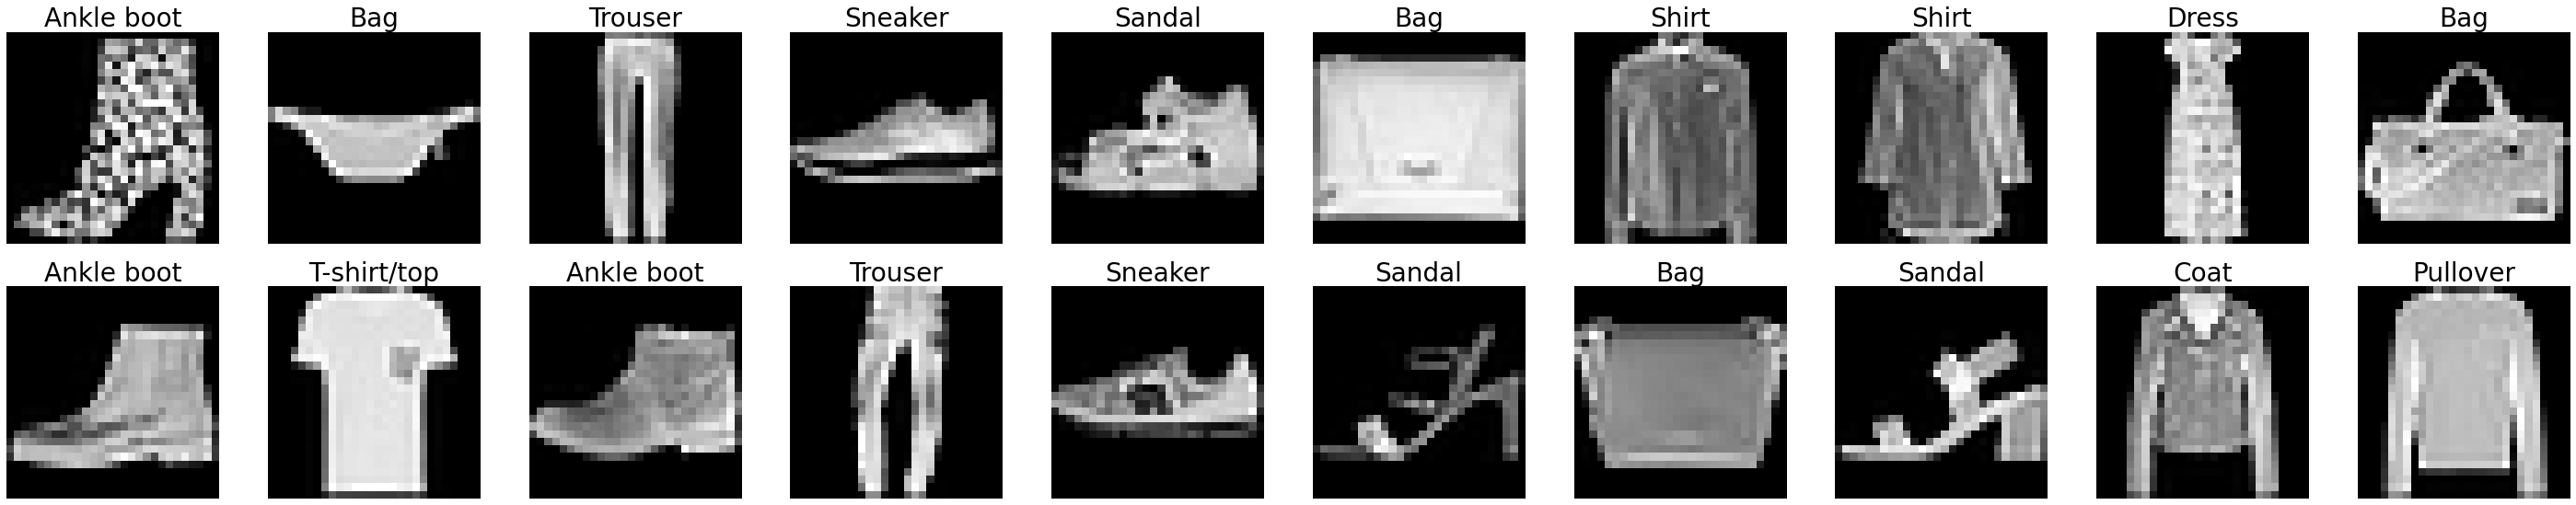

In [21]:
how_many_to_plot = 20
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True)

batch = next(iter(train_loader))


plt.figure(figsize=(50,50))
for i, batch in enumerate(train_loader, start=1):
    image, label = batch
    plt.subplot(10, 10, i)
    plt.imshow(image.reshape(28,28), cmap='gray')
    plt.axis('off')
    plt.title(train_set.classes[label.item()], fontsize=28)
    if (i >= how_many_to_plot):
        break

plt.show()

In [22]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        # Defining a 2D convolution layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)

    def forward(self, t):
        # (1) input layer
        t = t
        
        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (4) hidden linear layer
        t = t.reshape(-1, 12 * 4 * 4)
        t = self.fc1(t)
        t = F.relu(t)

        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)

        # (6) output layer
        t = self.out(t)

        return t

In [23]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [25]:
class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

In [26]:
class RunManager():
    def __init__(self):

        self.epoch_count = 0
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.epoch_start_time = None

        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None

        self.network = None
        self.loader = None
        self.tb = None

    def begin_run(self, run, network, loader):

        self.run_start_time = time.time()

        self.run_params = run
        self.run_count += 1

        self.network = network
        self.loader = loader
        self.tb = SummaryWriter(comment=f'-{run}')

        images, labels = next(iter(self.loader))
        grid = torchvision.utils.make_grid(images)

        self.tb.add_image('images', grid)
        self.tb.add_graph(self.network, images)
    
    def end_run(self):
        self.tb.close()
        self.epoch_count = 0

    def begin_epoch(self):
        self.epoch_start_time = time.time()

        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_num_correct = 0

    def end_epoch(self):

        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time

        loss = self.epoch_loss / len(self.loader.dataset)
        accuracy = self.epoch_num_correct / len(self.loader.dataset)

        self.tb.add_scalar('Loss', loss, self.epoch_count)
        self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)

        for name, param in self.network.named_parameters():
            self.tb.add_histogram(name, param, self.epoch_count)
            self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)

        results = OrderedDict()
        results["run"] = self.run_count
        results["epoch"] = self.epoch_count
        results["loss"] = loss
        results["accuracy"] = accuracy
        results["epoch duration"] = epoch_duration
        results["run duration"] = run_duration

        for k, v in self.run_params._asdict().items(): results[k] = v
        self.run_data.append(results)
        df = pd.DataFrame.from_dict(self.run_data, orient='columns')

        clear_output(wait=True)
        display(df)

    def track_loss(self, loss):
        self.epoch_loss += loss.item() * self.loader.batch_size

    def track_num_correct(self, preds, labels):
        self.epoch_num_correct += self._get_num_correct(preds, labels)

    @torch.no_grad()
    def _get_num_correct(self, preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()

    
    def save(self, fileName):

        pd.DataFrame.from_dict(
            self.run_data,
            orient = 'columns'
        ).to_csv(f'{fileName}.csv')

        with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [33]:
params = OrderedDict(
    lr = [0.01, 0.01],
    batch_size = [1000, 10000]
)

m = RunManager()
for run in RunBuilder.get_runs(params):
    comment = f'-{run}'

    # Defnining the model
    network = Network()
    print(network)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=run.batch_size)
    # Optimizer
    optimizer = optim.Adam(network.parameters(), lr=run.lr)

    m.begin_run(run, network, train_loader)
    for epoch in range(10):
        m.begin_epoch()

        for batch in train_loader:
            images, labels = batch

            # Pass Batch
            preds = network(images)
            # Calculated loss
            loss = F.cross_entropy(preds, labels)

            # Zero Gradients
            optimizer.zero_grad()
            # Calculate Gradients
            loss.backward()
            # Update Weights
            optimizer.step()

            m.track_loss(loss)
            m.track_num_correct(preds, labels)
        
        m.end_epoch()
    m.end_run()

m.save('results')

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size
0,1,1,4.048686,0.100250,16.445300,17.285550,0.10,1000
1,1,2,2.304414,0.100367,16.459928,33.793908,0.10,1000
2,1,3,2.304512,0.100383,16.427647,50.275700,0.10,1000
3,1,4,2.304494,0.101933,16.859349,67.184781,0.10,1000
4,1,5,2.304625,0.101100,16.394170,83.630176,0.10,1000
5,1,6,2.304197,0.101050,17.039352,100.714471,0.10,1000
6,1,7,2.304076,0.099933,16.814280,117.577206,0.10,1000
7,1,8,2.304145,0.099933,16.327619,133.949378,0.10,1000
8,1,9,2.304200,0.099933,16.321781,150.316650,0.10,1000
9,1,10,2.304247,0.099833,16.247947,166.611616,0.10,1000
